In [1]:
# Importação de bibliotecas e módulos
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import numpy.random as random
%matplotlib inline

In [2]:
# Opções e funções 


def coef_votos(df_votos, col_num, col_votos, bolsonaro, pt):
    df_votos = df_votos[['NR_TURNO', col_num, col_votos, 'SG_UF']]
    df_votos = df_votos[df_votos['NR_TURNO']==2]
    df_votos.drop(columns=['NR_TURNO'], inplace=True)
    df_votos = pd.pivot_table(df_votos, index=["SG_UF"], columns=[col_num], values=[col_votos], aggfunc=np.sum)
    df_votos['Coef']= df_votos[(col_votos, bolsonaro)]-df_votos[(col_votos, pt)]
    df_votos = df_votos['Coef']
    return df_votos


def coef_votos_prop(df_votos, col_num, col_votos, bolsonaro, pt):
    df_votos = df_votos[['NR_TURNO', col_num, col_votos, 'SG_UF']]
    df_votos = df_votos[df_votos['NR_TURNO']==2]
    df_votos.drop(columns=['NR_TURNO'], inplace=True)
    df_votos = pd.pivot_table(df_votos, index=["SG_UF"], columns=[col_num], values=[col_votos], aggfunc=np.sum)
    df_votos['Coef']= (df_votos[(col_votos, bolsonaro)]-df_votos[(col_votos, pt)])/(df_votos[(col_votos, bolsonaro)]+df_votos[(col_votos, pt)])
    df_votos = df_votos['Coef']
    return df_votos


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.rcParams['axes.formatter.useoffset'] = False

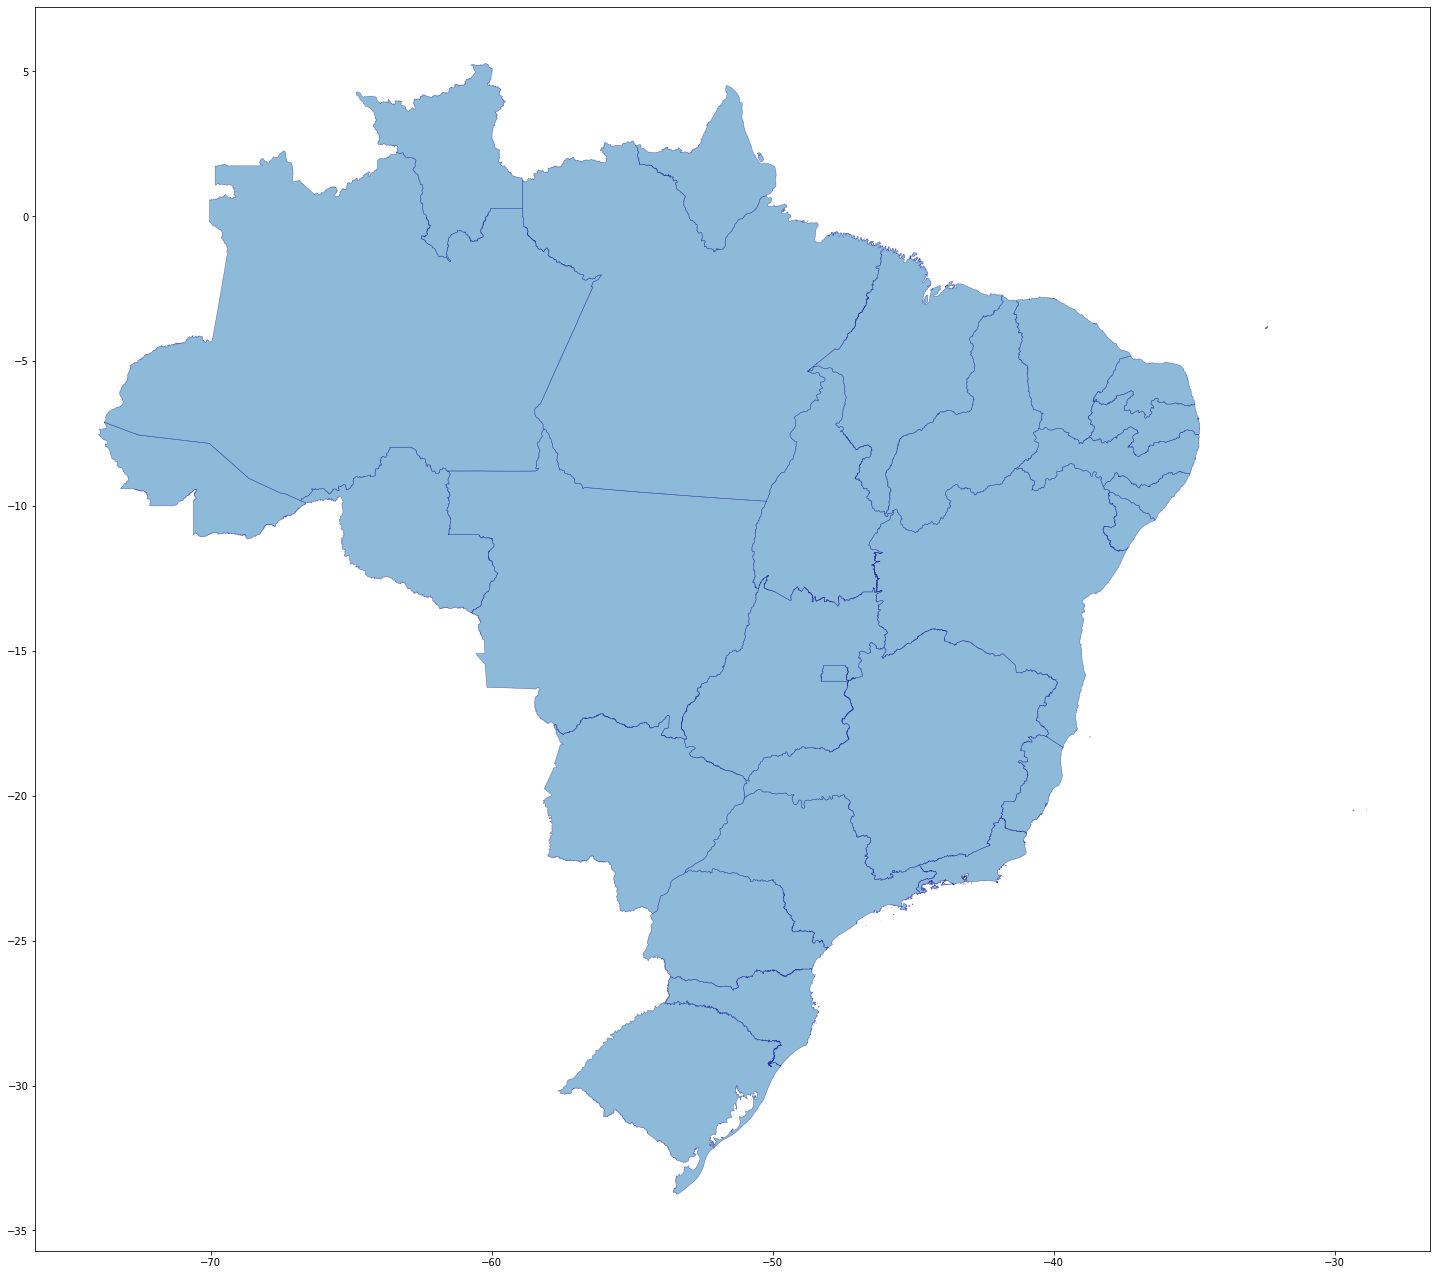

In [3]:
# Abrindo o shape
mapa = gpd.read_file('BR_UF_2020.shp')
ax = mapa.plot(figsize=(25, 25), edgecolor='darkblue', linewidth=0.5, alpha=0.5)
plt.show()

In [4]:
print(mapa.columns)

Index(['CD_UF', 'NM_UF', 'SIGLA_UF', 'NM_REGIAO', 'geometry'], dtype='object')


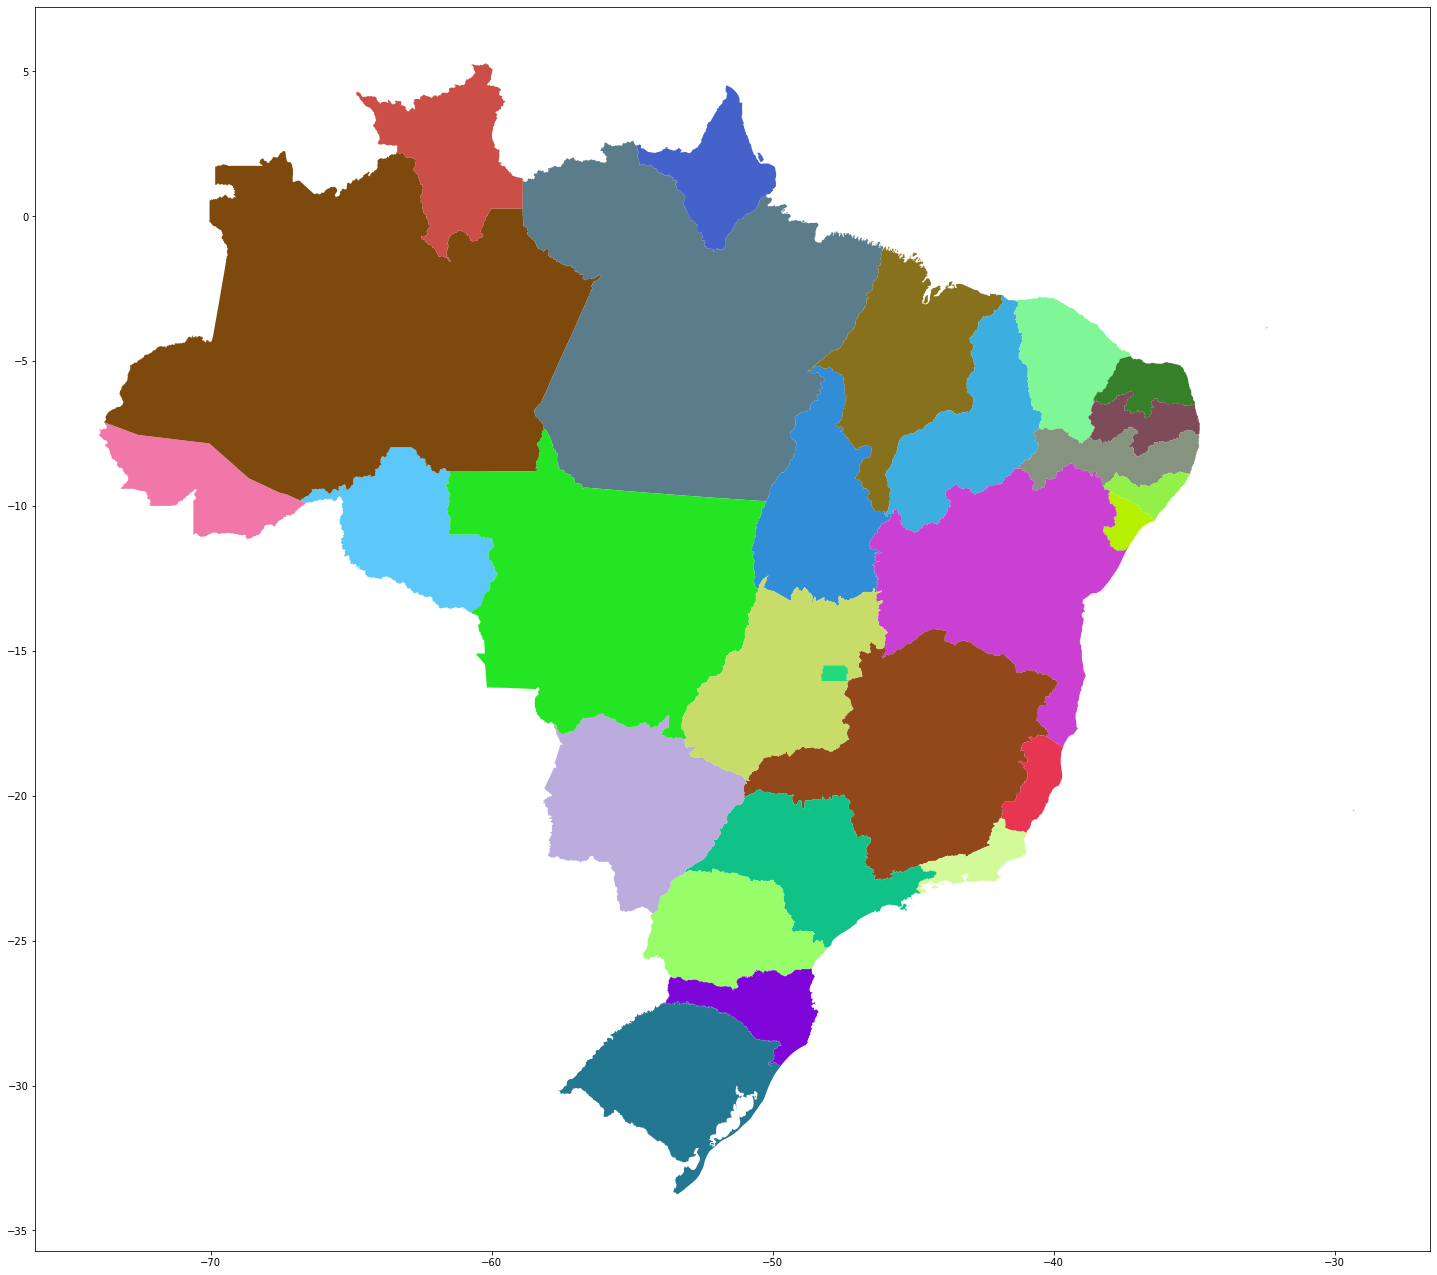

In [5]:
# Fazendo um mapa com cores aleatórias das Regiões do Brasil
random.seed(1)
cods = mapa['NM_UF'].value_counts().index.to_series().reset_index(drop=True).to_frame(name="NM_UF")
cods['cores'] = ["#"+''.join([random.choice(list('0123456789ABCDEF')) for j in range(6)])
             for i in range(len(cods))]
mapa1 = mapa.merge(cods, left_on='NM_UF', right_on='NM_UF', how='outer')
mapa1 = gpd.GeoDataFrame(mapa1)
mapa1.plot(figsize=(25, 25), color=mapa1['cores'])
plt.show()

In [6]:
# Gerando coeficientes de voto
df = pd.read_csv("votacao_secao_2022_BR.csv", sep=";", encoding='ISO-8859-1')
print(df.columns)

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'CD_CARGO', 'DS_CARGO',
       'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS', 'NR_LOCAL_VOTACAO',
       'SQ_CANDIDATO', 'NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO'],
      dtype='object')


In [7]:
df = df[['NR_TURNO','NR_VOTAVEL','QT_VOTOS', 'SG_UF']]
df = df[df['NR_TURNO']==2]
df.drop(columns=['NR_TURNO'], inplace=True)
df = pd.pivot_table(df, index=["SG_UF"], columns=["NR_VOTAVEL"], values=["QT_VOTOS"], aggfunc=np.sum)
df['Coef']= df[('QT_VOTOS', 22)]/df[('QT_VOTOS', 13)]
df = df['Coef']

print(df.min(), df.max()) # Os valores vão de 0.3 a 3.2, e 
# 1 equivale a mesma votação para ambos os candidatos em um estado
# 0,5 e 2 equivalem a votações em que Lula e Bolsonaro tiveram o dobro que seu adversário, respectivamente

0.30106363161127847 3.1807591467048026


In [8]:
# Unindo geodataframe com o dataframe
mapa2 = mapa.merge(df, left_on='SIGLA_UF', right_on='SG_UF', how='left')
mapa2 = gpd.GeoDataFrame(mapa2)

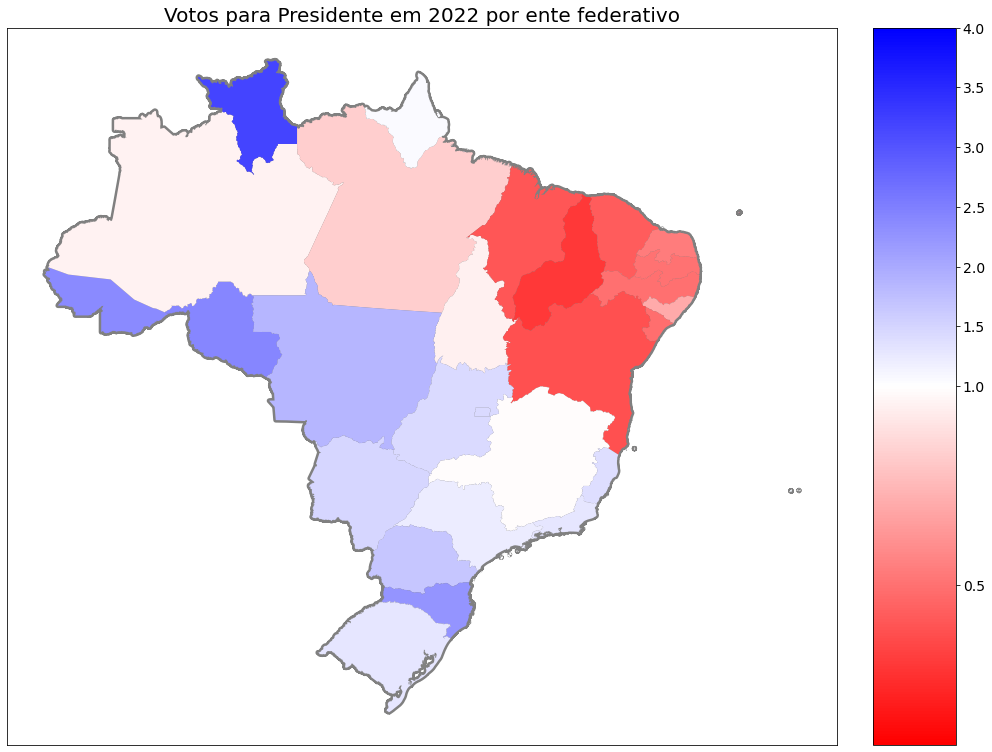

In [9]:
# Gerando o mapa de votos

plt.rcParams.update({'font.size': 14})
cmap_bwr = plt.cm.get_cmap('bwr').reversed()

fig, ax = plt.subplots(figsize=(14,14))
mapa2.plot(ax= ax, edgecolor='gray', linewidth=5, zorder= 1) # Delineando o mapa
ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
offset = mcolors.TwoSlopeNorm(vmin=0.1, vcenter=1, vmax=4) # Distância das cores
cax = make_axes_locatable(ax).append_axes("right", size="10%", pad=0.5) # Barra lateral
mapa2.plot(ax= ax, cax= cax, column='Coef', cmap=cmap_bwr, norm= offset, zorder= 2)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=offset, cmap=cmap_bwr), cax=cax)
ax.set_title('Votos para Presidente em 2022 por ente federativo', fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
# Aqui, tentei equilibrar cor e porcentagem de votos.
# Mais me importa chamar atenção pros Estados em que cada candidato foi melhor
# do que colorir o mapa com a "vantagem absoluta" de um candidato sobre o outro

# O trabalho de criar mapas é estético, e o criador tem responsabilidade,
# por meio de sua escala de cores, sobre qual informação é passada!

In [11]:
# Diferença de votos considerando 2018

df18 = pd.read_csv("votacao_partido_munzona_2018_BR.csv", sep=";", encoding='ISO-8859-1')
df18 = coef_votos(df18, col_num='NR_PARTIDO', col_votos='QT_VOTOS_NOMINAIS', bolsonaro=17, pt=13)

df22 = pd.read_csv("votacao_secao_2022_BR.csv", sep=";", encoding='ISO-8859-1')
df22 = coef_votos(df22, col_num='NR_VOTAVEL', col_votos='QT_VOTOS', bolsonaro=22, pt=13)

df_diferença = df22 - df18

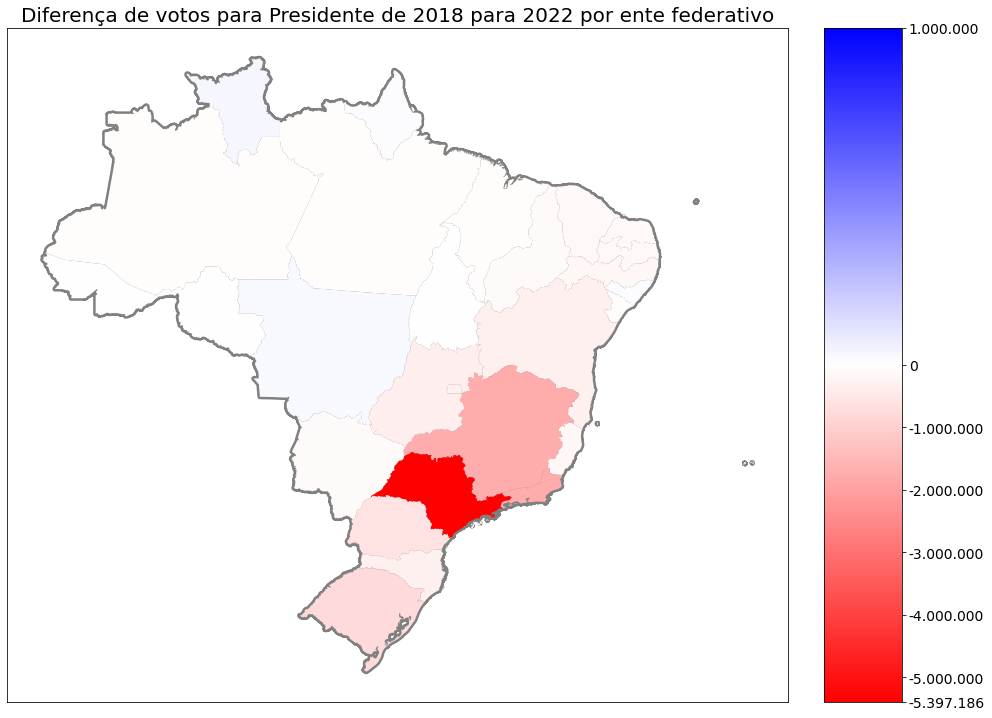

In [12]:
# Gerando mapa da diferença de votos 

mapa3 = mapa.merge(df_diferença, left_on='SIGLA_UF', right_on='SG_UF', how='left')
mapa3 = gpd.GeoDataFrame(mapa3)

plt.rcParams.update({'font.size': 14})
cmap_bwr = plt.cm.get_cmap('bwr').reversed()

fig, ax = plt.subplots(figsize=(14,14))
mapa3.plot(ax= ax, edgecolor='gray', linewidth=5, zorder= 1) # Delineando o mapa
ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)

offset = mcolors.TwoSlopeNorm(vmin=mapa3['Coef'].min(), vcenter=0, vmax=10**6) # Distância das cores
cax = make_axes_locatable(ax).append_axes("right", size="10%", pad=0.5) # Barra lateral
mapa3.plot(ax= ax, cax= cax, column='Coef', cmap=cmap_bwr, norm= offset, zorder= 2)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=offset, cmap=cmap_bwr), cax=cax)
ticks = [mapa3['Coef'].min(), -5*10**6, -4*10**6, -3*10**6, -2*10**6, -1*10**6, 0 , 10**6]
ticklabels = ['{:,.0f}'.format(x).replace(',','.') for x in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)
cbar.formatter.set_scientific(False)

ax.set_title('Diferença de votos para Presidente de 2018 para 2022 por ente federativo', fontsize=20)

plt.tight_layout()
plt.show()

In [13]:
# Aqui, foquei na diferença absoluta de votos (com alguma relatividade).
# Como podemos ver, os estados do Sul e Sudeste foram os que mais contribuíram pra virada eleitoral petista.

In [14]:
# Fazendo o proporcional do gráfico anterior pq o Cava é chato

dfp18 = pd.read_csv("votacao_partido_munzona_2018_BR.csv", sep=";", encoding='ISO-8859-1')
dfp18 = coef_votos_prop(dfp18, col_num='NR_PARTIDO', col_votos='QT_VOTOS_NOMINAIS', bolsonaro=17, pt=13)

dfp22 = pd.read_csv("votacao_secao_2022_BR.csv", sep=";", encoding='ISO-8859-1')
dfp22 = coef_votos_prop(dfp22, col_num='NR_VOTAVEL', col_votos='QT_VOTOS', bolsonaro=22, pt=13)

dfp_diferença = dfp22 - dfp18

[-0.25, -0.15, 0, 0.15, 0.25]


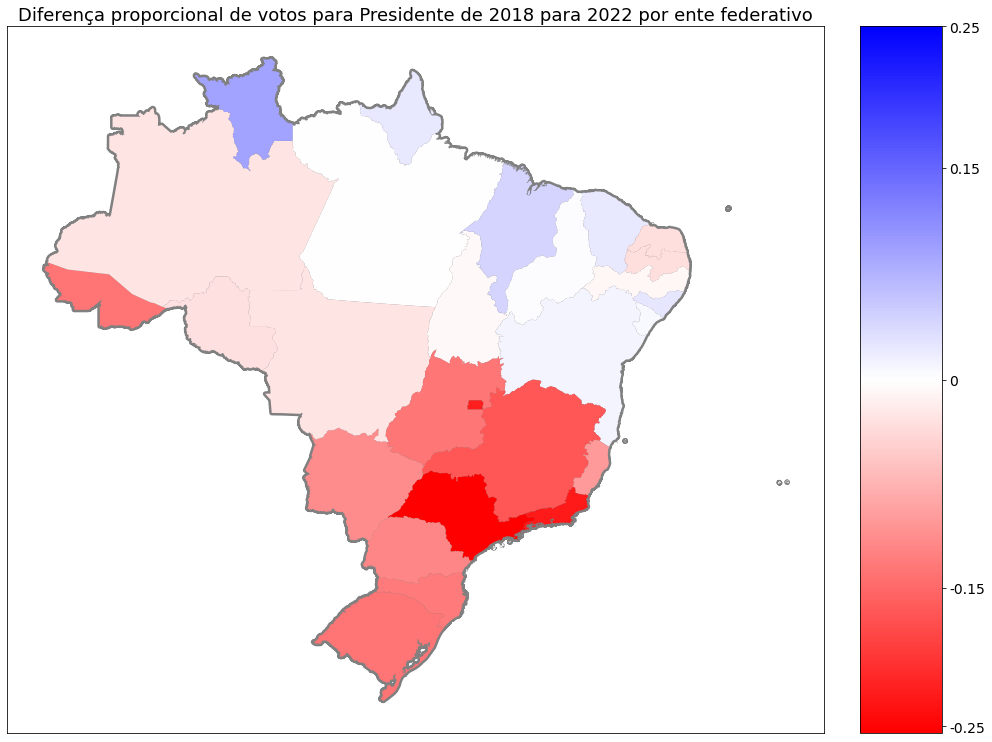

In [23]:
# Gerando mapa da diferença proporcional de votos 

mapa4 = mapa.merge(dfp_diferença, left_on='SIGLA_UF', right_on='SG_UF', how='left')
mapa4 = gpd.GeoDataFrame(mapa4)

plt.rcParams.update({'font.size': 14})
cmap_bwr = plt.cm.get_cmap('bwr').reversed()

fig, ax = plt.subplots(figsize=(14,14))
mapa4.plot(ax= ax, edgecolor='gray', linewidth=5, zorder= 1) # Delineando o mapa
ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)

offset = mcolors.TwoSlopeNorm(vmin=mapa4['Coef'].min(), vcenter=0, vmax=0.25) # Distância das cores
cax = make_axes_locatable(ax).append_axes("right", size="10%", pad=0.5) # Barra lateral
mapa4.plot(ax= ax, cax= cax, column='Coef', cmap=cmap_bwr, norm= offset, zorder= 2)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=offset, cmap=cmap_bwr), cax=cax)
ticks = [-0.25, -0.15, 0, 0.15, 0.25]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.formatter.set_scientific(False)

ax.set_title('Diferença proporcional de votos para Presidente de 2018 para 2022 por ente federativo', fontsize=18)

plt.tight_layout()
plt.show()